# Telco Coustomer Churn

This dataset comes from Kaggle.\
\
**Context**\
"Predict behavior to retain customers. You can analyze all relevant customer data and develop focused customer retention programs." [IBM Sample Data Sets]

**Content**\
Each row represents a customer, each column contains customer’s attributes described on the column Metadata.

The data set includes information about:
- Customers who left within the last month – the column is called Churn
- Services that each customer has signed up for – phone, multiple lines, internet, online security, online backup, device protection, tech support, and streaming TV and movies
- Customer account information – how long they’ve been a customer, contract, payment method, paperless billing, monthly charges, and total charges
- Demographic info about customers – gender, age range, and if they have partners and dependents\

**Inspiration**\
To explore this type of models and learn more about the subject.\
New version from IBM:
https://community.ibm.com/community/user/businessanalytics/blogs/steven-macko/2019/07/11/telco-customer-churn-1113 

# 1. Load module and data

In [253]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder, OrdinalEncoder, KBinsDiscretizer
from sklearn.compose import ColumnTransformer

from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score, classification_report
import time
import inspect, re

from sklearn.base import BaseEstimator, TransformerMixin

In [177]:
import os
os.chdir(r'F:\Data_Science\Machine_learning\Cases\Case_Four')

In [178]:
tcc = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv')
tcc.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [179]:
tcc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [180]:
tcc.describe()   # only 3 numerical features, others are categorical features

,SeniorCitizen,tenure,MonthlyCharges
count,7043.000000,7043.000000,7043.000000
mean,0.162147,32.371149,64.761692
std,0.368612,24.559481,30.090047
min,0.000000,0.000000,18.250000
25%,0.000000,9.000000,35.500000
50%,0.000000,29.000000,70.350000
75%,0.000000,55.000000,89.850000
max,1.000000,72.000000,118.750000


# 2. EDA

## 2.1 Duplicates

In [181]:
tcc['customerID'].nunique() == tcc.shape[0]

True

There is no duplicate customer ID



In [182]:
tcc.duplicated().sum()

0

## 2.2 Date type feature

In [183]:
tcc['tenure']   # not 'year-month-day'

0        1
1       34
2        2
3       45
4        2
        ..
7038    24
7039    72
7040    11
7041     4
7042    66
Name: tenure, Length: 7043, dtype: int64

In [184]:
tcc['tenure'].nunique()

73

We can see that 'tenure' is not labeled as 'year-month-day', but a continuous value. So we infer that it is already discretizated. 
In the third quarter, user behavior occurred within 73 days, so the tenure has 73 values. Since the dictionary sorting has been performed, the original information (time difference, day of week, etc.) has been removed.

## Divide categorical feature and numeric feature

In [185]:
# categorical features
categorical_cols = tcc.select_dtypes('object').columns

# numeric features
numeric_cols = ['MonthlyCharges', 'TotalCharges']

# label
target = 'Churn'

## 2.3 Missing value

In [186]:
tcc.isnull().sum()

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

There is no missing value, but note: if there is ' ' in the dataset, isnull() cannot detect it

In [187]:
for i in categorical_cols:
    print(tcc[i].value_counts())
    print('========================')

7590-VHVEG    1
3791-LGQCY    1
6008-NAIXK    1
5956-YHHRX    1
5365-LLFYV    1
             ..
9796-MVYXX    1
2637-FKFSY    1
1552-AAGRX    1
4304-TSPVK    1
3186-AJIEK    1
Name: customerID, Length: 7043, dtype: int64
Male      3555
Female    3488
Name: gender, dtype: int64
No     3641
Yes    3402
Name: Partner, dtype: int64
No     4933
Yes    2110
Name: Dependents, dtype: int64
Yes    6361
No      682
Name: PhoneService, dtype: int64
No                  3390
Yes                 2971
No phone service     682
Name: MultipleLines, dtype: int64
Fiber optic    3096
DSL            2421
No             1526
Name: InternetService, dtype: int64
No                     3498
Yes                    2019
No internet service    1526
Name: OnlineSecurity, dtype: int64
No                     3088
Yes                    2429
No internet service    1526
Name: OnlineBackup, dtype: int64
No                     3095
Yes                    2422
No internet service    1526
Name: DeviceProtection, dtype: in

It raises error when conducting tcc['TotalCharges'].astype(float), so we think there is space in TotalCharges column

In [188]:
# convert ' ' to np.nan
tcc['TotalCharges'] = tcc['TotalCharges'].apply(lambda x: x if x != ' ' else np.nan)

In [189]:
# check missing values
tcc['TotalCharges'].isnull().sum()

11

11 rows have missing value, check those rows

In [190]:
tcc[tcc['TotalCharges'].isnull()]

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
488,4472-LVYGI,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,...,Yes,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),52.55,NaN,No
753,3115-CZMZD,Male,0,No,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.25,NaN,No
936,5709-LVOEQ,Female,0,Yes,Yes,0,Yes,No,DSL,Yes,...,Yes,No,Yes,Yes,Two year,No,Mailed check,80.85,NaN,No
1082,4367-NUYAO,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.75,NaN,No
1340,1371-DWPAZ,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,...,Yes,Yes,Yes,No,Two year,No,Credit card (automatic),56.05,NaN,No
3331,7644-OMVMY,Male,0,Yes,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,19.85,NaN,No
3826,3213-VVOLG,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.35,NaN,No
4380,2520-SGTTA,Female,0,Yes,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.00,NaN,No
5218,2923-ARZLG,Male,0,Yes,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,One year,Yes,Mailed check,19.70,NaN,No
6670,4075-WKNIU,Female,0,Yes,Yes,0,Yes,Yes,DSL,No,...,Yes,Yes,Yes,No,Two year,No,Mailed check,73.35,NaN,No


The 'tenure' of 11 users are all 0, which means that they joined the network at the last day before the end of the data collection period, so they don't have previous comsuption records despite consumption record for the current month. Therefore, we can record these 11 missing values as 0, meaning the previous consumption records of these users are 0.

In [191]:
tcc['TotalCharges'] = tcc['TotalCharges'].fillna(0)

In [192]:
tcc['TotalCharges'].isnull().sum()

0

In [193]:
# Convert numeric features to float
tcc['TotalCharges'] = tcc['TotalCharges'].astype(float)

In [194]:
tcc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


## 2.4 Outliers



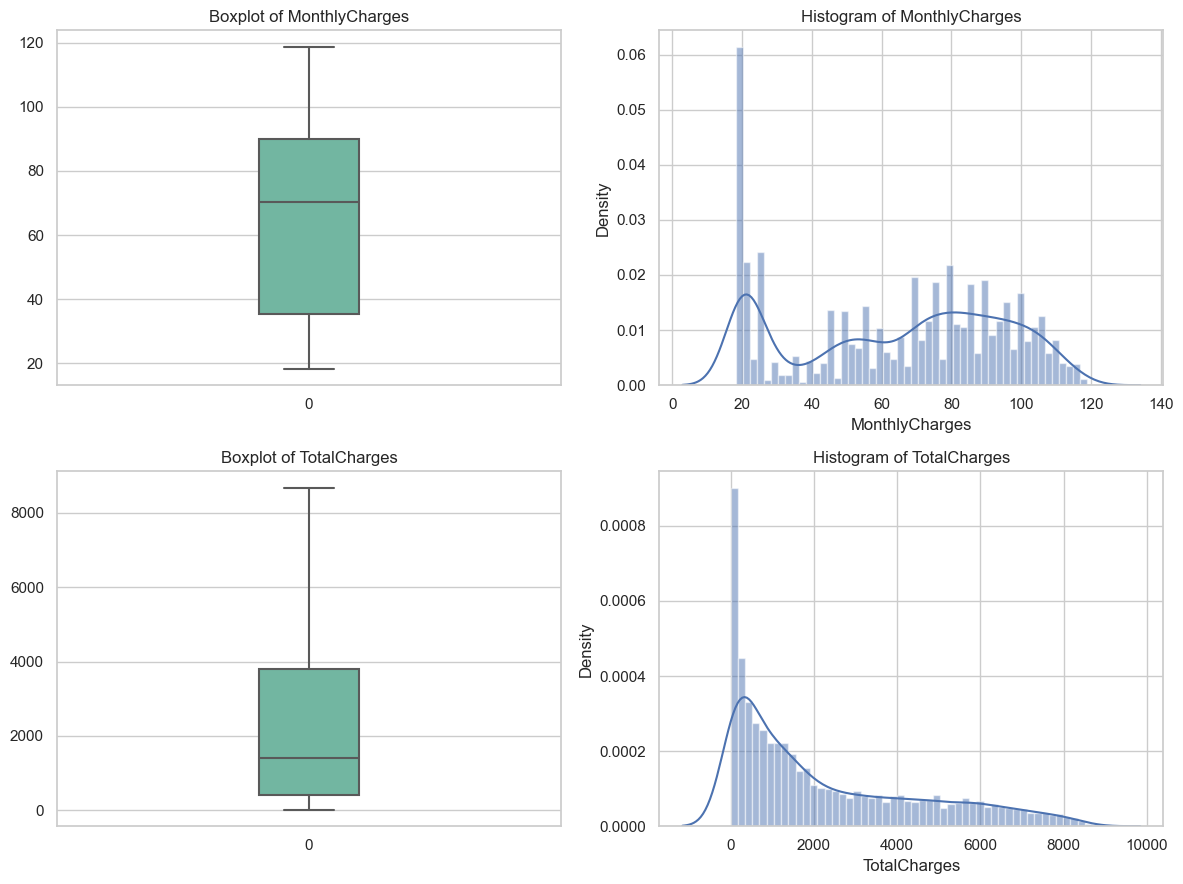

In [195]:
fig, axes = plt.subplots(ncols = 2, nrows = 2, figsize = (12, 9))

sns.boxplot(data = tcc['MonthlyCharges'], width = 0.2, ax = axes[0, 0], palette = 'Set2')
axes[0, 0].set(title = 'Boxplot of MonthlyCharges')

sns.distplot(tcc['MonthlyCharges'], ax = axes[0, 1], kde = True, bins = 50, hist_kws={'alpha': 0.5})
axes[0, 1].set(title = 'Histogram of MonthlyCharges')

sns.boxplot(data = tcc['TotalCharges'], width = 0.2, ax = axes[1, 0], palette = 'Set2')
axes[1, 0].set(title = 'Boxplot of TotalCharges')

sns.distplot(tcc['TotalCharges'], ax = axes[1, 1], kde = True, bins = 50, hist_kws={'alpha': 0.5})
axes[1, 1].set(title = 'Histogram of TotalCharges')

plt.tight_layout()
plt.show()

There are no outliers

## 2.5 Correlation

### 2.5.1 Distribution of label

Text(-0.3, 5200, 'Non-Churn rate: 73.46%')

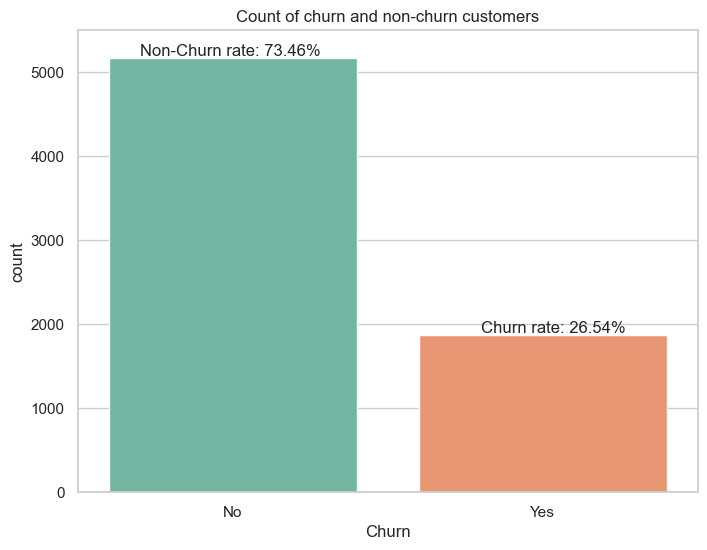

In [196]:
# The distribution of label
churn_percentage = round((len(tcc[tcc['Churn'] == 'Yes']) / tcc.shape[0]) * 100, 2)
non_churn_percentage = round((len(tcc[tcc['Churn'] == 'No']) / tcc.shape[0]) * 100, 2)
plt.figure(figsize = (8, 6))
sns.countplot('Churn', data = tcc, dodge = False, palette = 'Set2')
plt.title('Count of churn and non-churn customers')
plt.ylim([0, 5500])
plt.text(0.8, 1900, s = 'Churn rate: ' + str(churn_percentage) + '%' )
plt.text(-0.3, 5200, s = 'Non-Churn rate: ' + str(non_churn_percentage) + '%' )

### 2.5.2 Correlation of features

In [197]:
# drop column id
tcc_tmp = tcc.iloc[:, 1:].copy()

In [198]:
# convert Yes/No in label to 1/0
tcc_tmp['Churn'].replace('Yes', 1, inplace = True)
tcc_tmp['Churn'].replace('No', 0, inplace = True)

In [199]:
# Convert to dummy variables
tcc_dummy = pd.get_dummies(tcc_tmp)
tcc_dummy.shape

(7043, 46)

In [200]:
# calcute correlations
tcc_dummy.corr()

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges,Churn,gender_Female,gender_Male,Partner_No,Partner_Yes,Dependents_No,...,StreamingMovies_Yes,Contract_Month-to-month,Contract_One year,Contract_Two year,PaperlessBilling_No,PaperlessBilling_Yes,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
SeniorCitizen,1.000000,0.016567,0.220173,0.103006,0.150889,0.001874,-0.001874,-0.016479,0.016479,0.211185,...,0.120176,0.138360,-0.046262,-0.117000,-0.156530,0.156530,-0.016159,-0.024135,0.171718,-0.153477
tenure,0.016567,1.000000,0.247900,0.826178,-0.352229,-0.005106,0.005106,-0.379697,0.379697,-0.159712,...,0.286111,-0.645561,0.202570,0.558533,-0.006152,0.006152,0.243510,0.233006,-0.208363,-0.233852
MonthlyCharges,0.220173,0.247900,1.000000,0.651174,0.193356,0.014569,-0.014569,-0.096848,0.096848,0.113890,...,0.627429,0.060165,0.004904,-0.074681,-0.352150,0.352150,0.042812,0.030550,0.271625,-0.377437
TotalCharges,0.103006,0.826178,0.651174,1.000000,-0.198324,0.000080,-0.000080,-0.317504,0.317504,-0.062078,...,0.520122,-0.444255,0.170814,0.354481,-0.158574,0.158574,0.185987,0.182915,-0.059246,-0.295758
Churn,0.150889,-0.352229,0.193356,-0.198324,1.000000,0.008612,-0.008612,0.150448,-0.150448,0.164221,...,0.061382,0.405103,-0.177820,-0.302253,-0.191825,0.191825,-0.117937,-0.134302,0.301919,-0.091683
gender_Female,0.001874,-0.005106,0.014569,0.000080,0.008612,1.000000,-1.000000,-0.001808,0.001808,0.010517,...,0.010487,0.003386,-0.008026,0.003695,-0.011754,0.011754,0.016024,-0.001215,-0.000752,-0.013744
gender_Male,-0.001874,0.005106,-0.014569,-0.000080,-0.008612,-1.000000,1.000000,0.001808,-0.001808,-0.010517,...,-0.010487,-0.003386,0.008026,-0.003695,0.011754,-0.011754,-0.016024,0.001215,0.000752,0.013744
Partner_No,-0.016479,-0.379697,-0.096848,-0.317504,0.150448,-0.001808,0.001808,1.000000,-1.000000,0.452676,...,-0.117412,0.280865,-0.082783,-0.248091,-0.014877,0.014877,-0.110706,-0.082029,0.083852,0.095125
Partner_Yes,0.016479,0.379697,0.096848,0.317504,-0.150448,0.001808,-0.001808,-1.000000,1.000000,-0.452676,...,0.117412,-0.280865,0.082783,0.248091,0.014877,-0.014877,0.110706,0.082029,-0.083852,-0.095125
Dependents_No,0.211185,-0.159712,0.113890,-0.062078,0.164221,0.010517,-0.010517,0.452676,-0.452676,1.000000,...,0.039741,0.231720,-0.068368,-0.204613,-0.111377,0.111377,-0.052021,-0.060267,0.150642,-0.059071


In [201]:
# correlation between features and label
tcc_dummy.corr()['Churn'].sort_values(ascending = False)

Churn                                      1.000000
Contract_Month-to-month                    0.405103
OnlineSecurity_No                          0.342637
TechSupport_No                             0.337281
InternetService_Fiber optic                0.308020
PaymentMethod_Electronic check             0.301919
OnlineBackup_No                            0.268005
DeviceProtection_No                        0.252481
MonthlyCharges                             0.193356
PaperlessBilling_Yes                       0.191825
Dependents_No                              0.164221
SeniorCitizen                              0.150889
Partner_No                                 0.150448
StreamingMovies_No                         0.130845
StreamingTV_No                             0.128916
StreamingTV_Yes                            0.063228
StreamingMovies_Yes                        0.061382
MultipleLines_Yes                          0.040102
PhoneService_Yes                           0.011942
gender_Femal

* Churn and Contract Month-to-month have a correlation coefficient of 0.4, indicating a positive relationship between the two. Accordingly, it is more likely that users sigh their contract by month will churn. 
* Conversely, tenure has a negative correlation with churn, meaning that the longer the tenure, the lower the likelihood of churning.

Visulize the correlation in heatmap and bar plot.

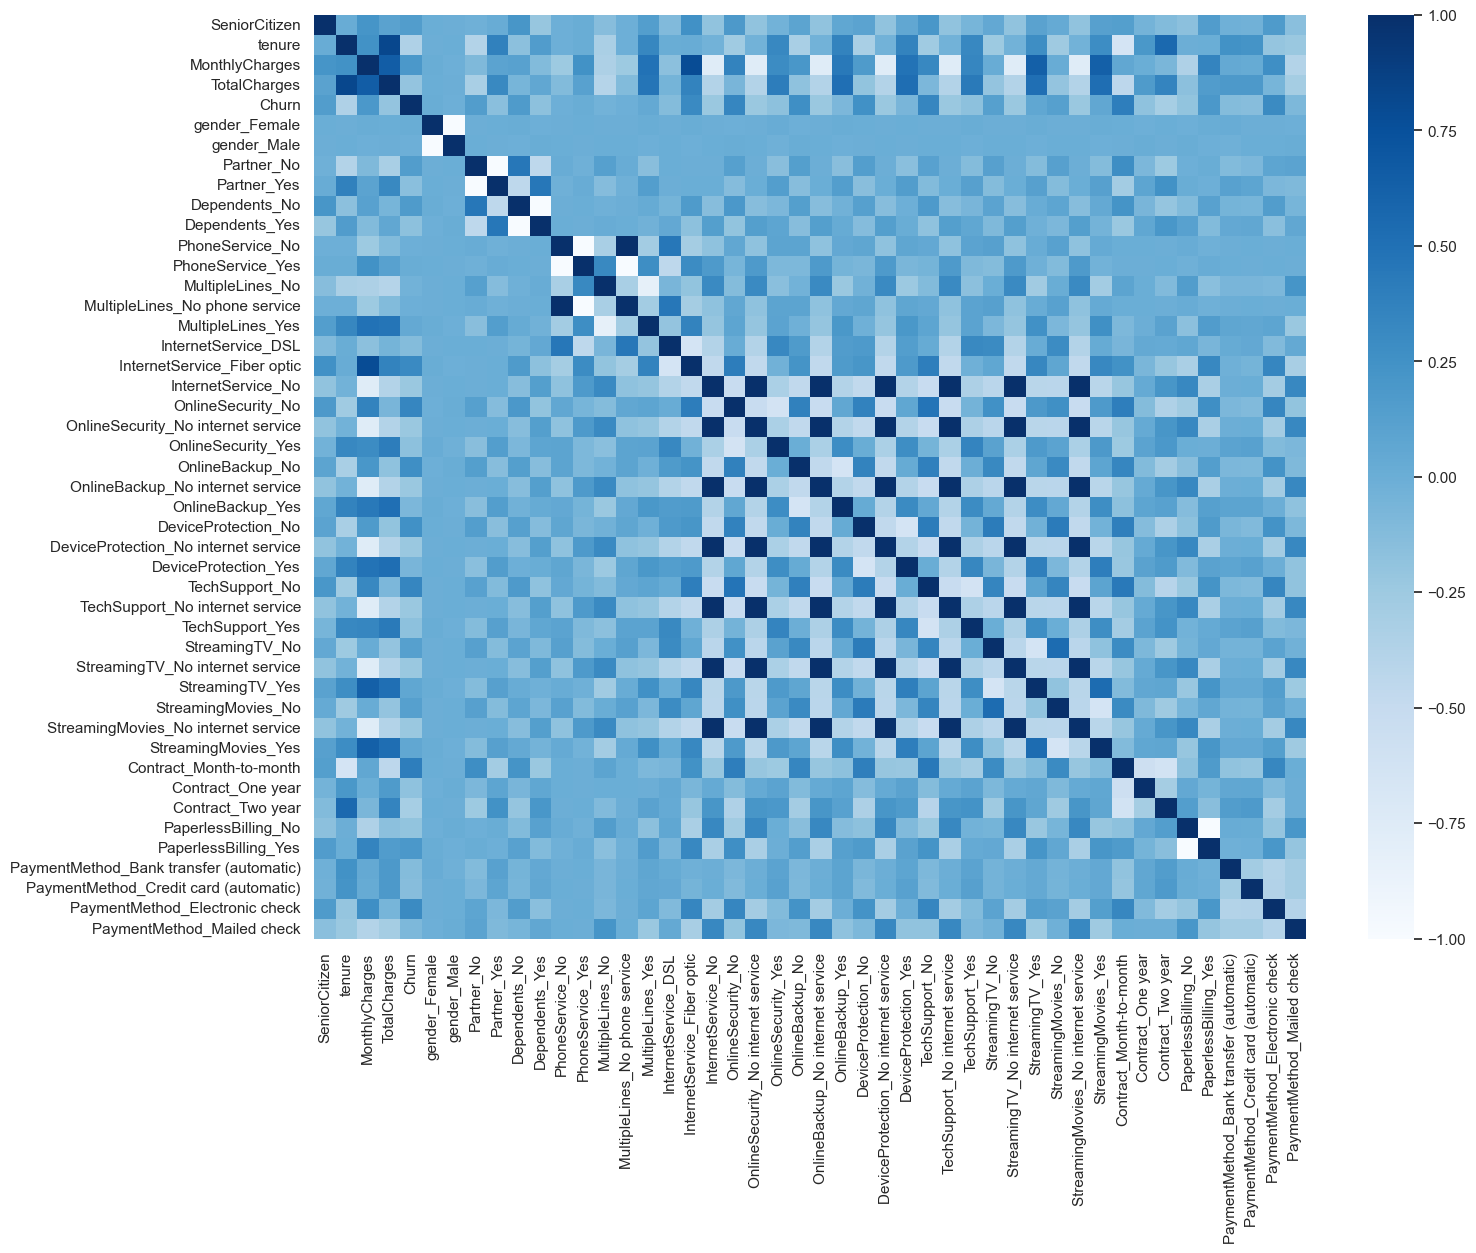

In [202]:
# heatmap
plt.figure(figsize=(16, 12))
sns.heatmap(tcc_dummy.corr(), cmap = 'Blues')
plt.show()

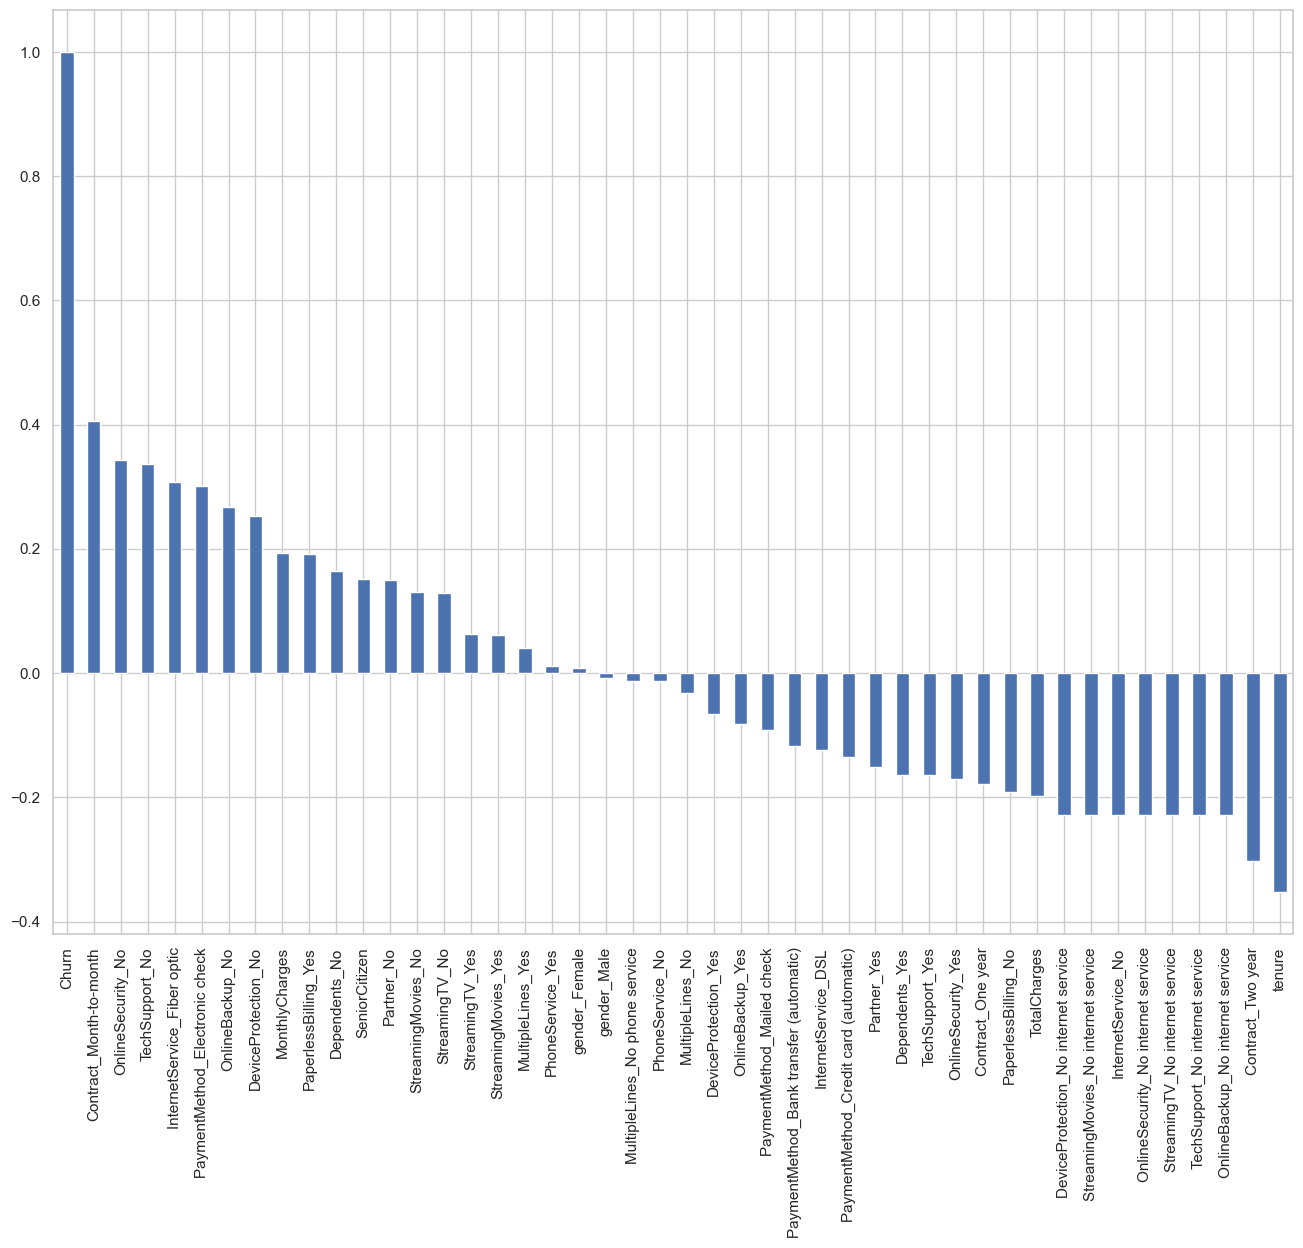

In [203]:
# Use barplot to plot the correlation more clearly
sns.set(style = 'whitegrid')
plt.figure(figsize = (16, 12))
tcc_dummy.corr()['Churn'].sort_values(ascending = False).plot(kind = 'bar')
plt.show()

## 2.6 Data Visualization

### 2.6.1 Categorical features

According to the description, we can divide 19 categorical features into 3 categories: account informationm, demographic information and service information

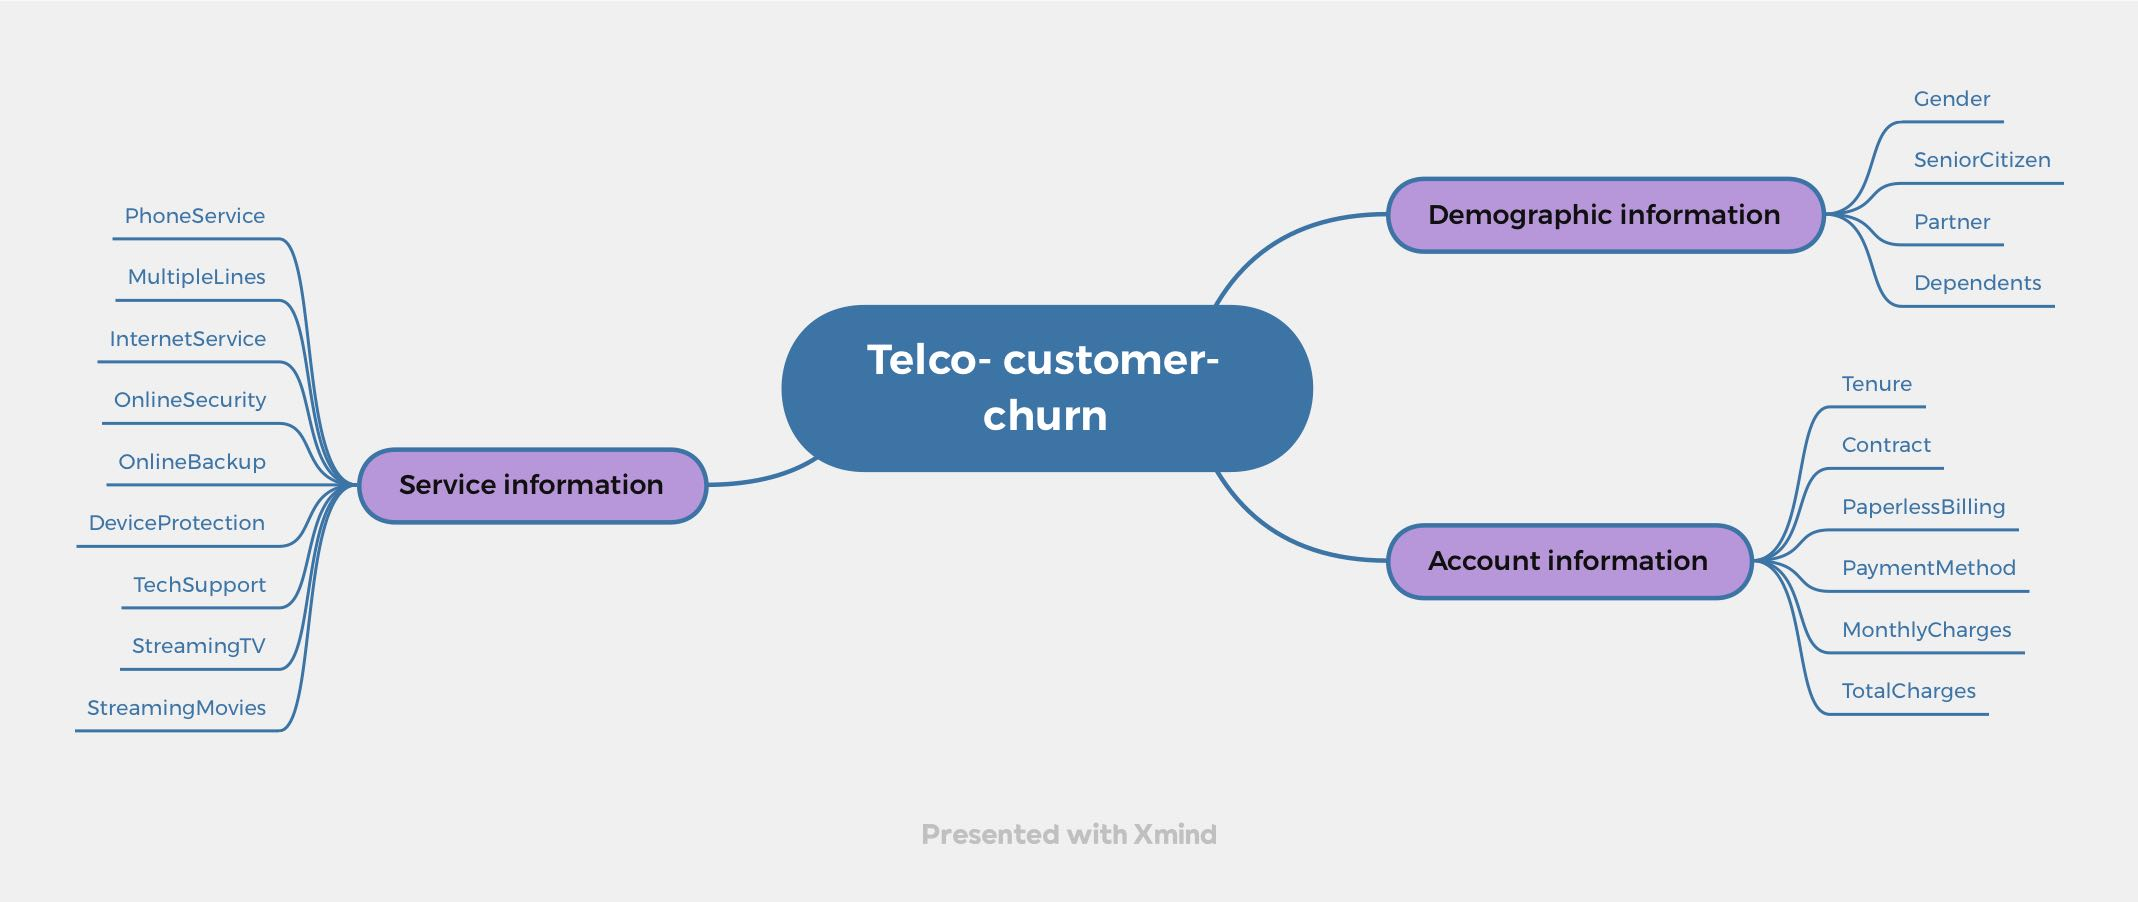

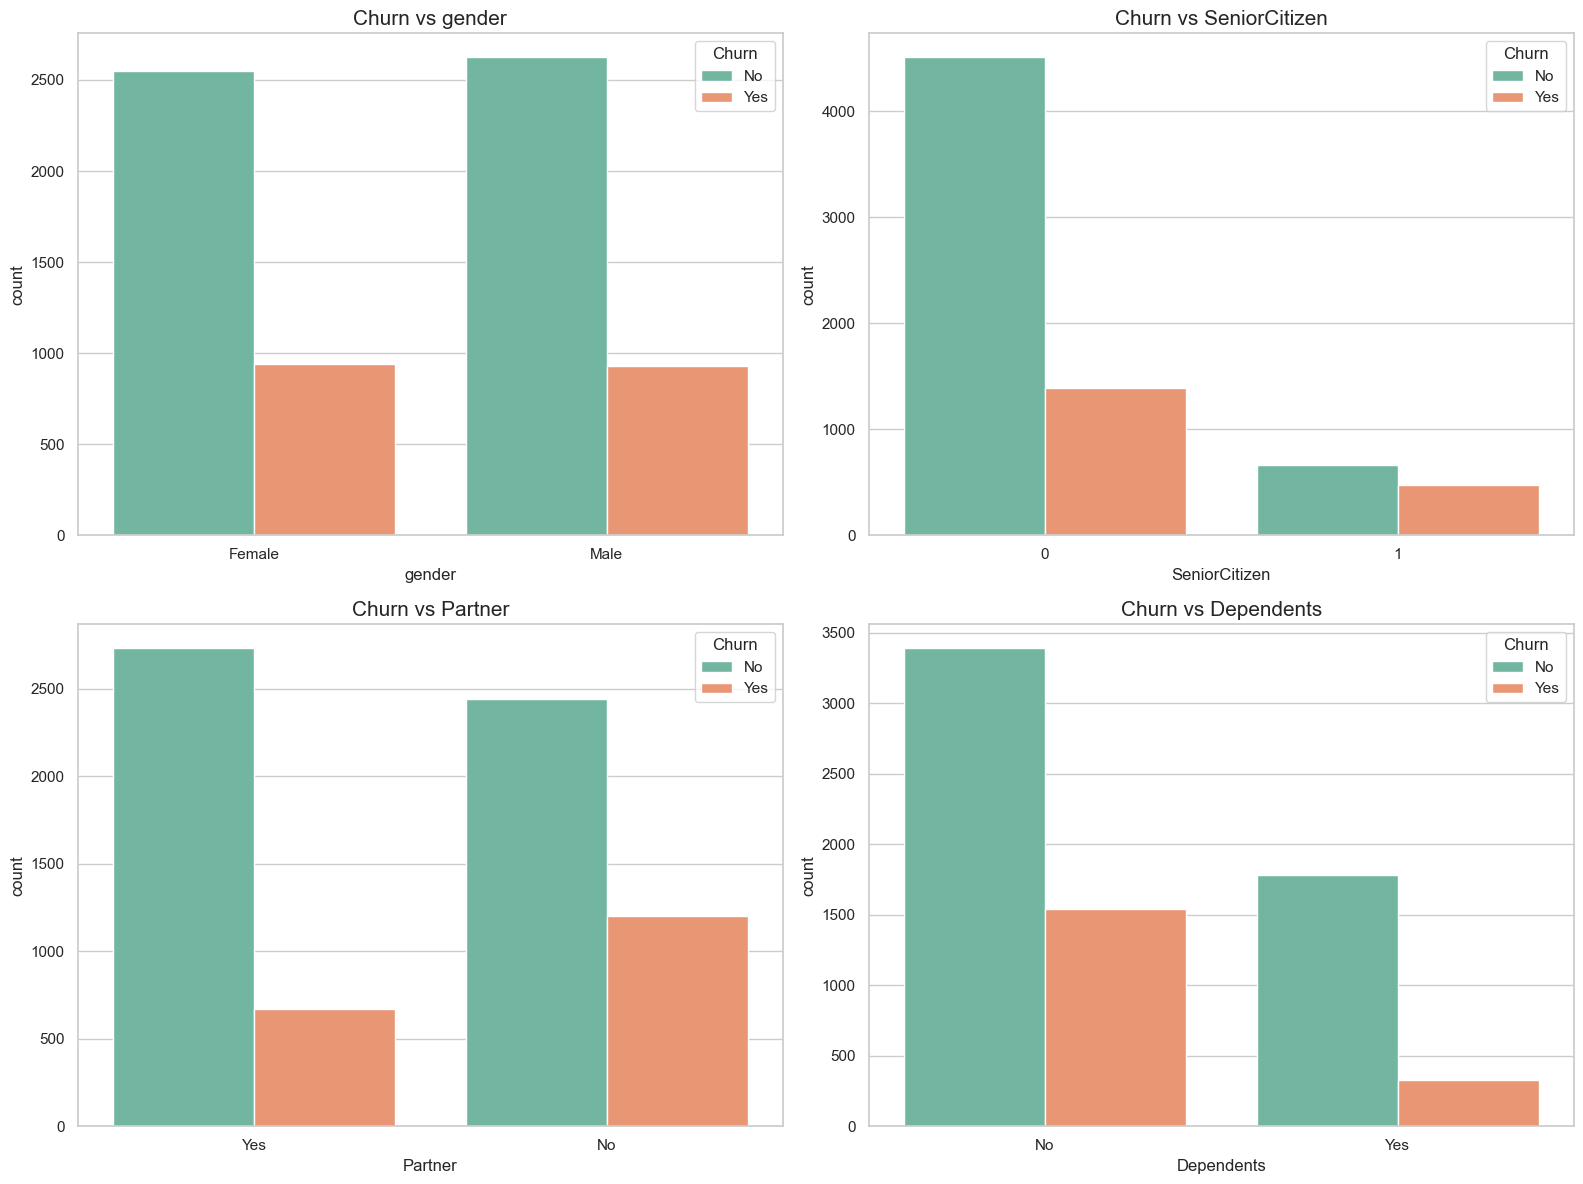

In [204]:
demographic = ["gender", "SeniorCitizen", "Partner", "Dependents"]

fig, axes = plt.subplots(nrows = 2, ncols = 2, figsize = (16, 12))
for i in range(len(demographic)):
    sns.countplot(x = demographic[i], hue = 'Churn', data = tcc, palette = 'Set2', ax = axes[i//2, i%2])
    axes[i//2, i%2].set_title('Churn vs {}'.format(demographic[i]), fontsize = 15)
    plt.tight_layout()

While gender has little impact on churn, older customers, unmarried users, and users who are not financially independent all have fairly high churn rates. When creating operational plans, attention must be paid to these three user segments.

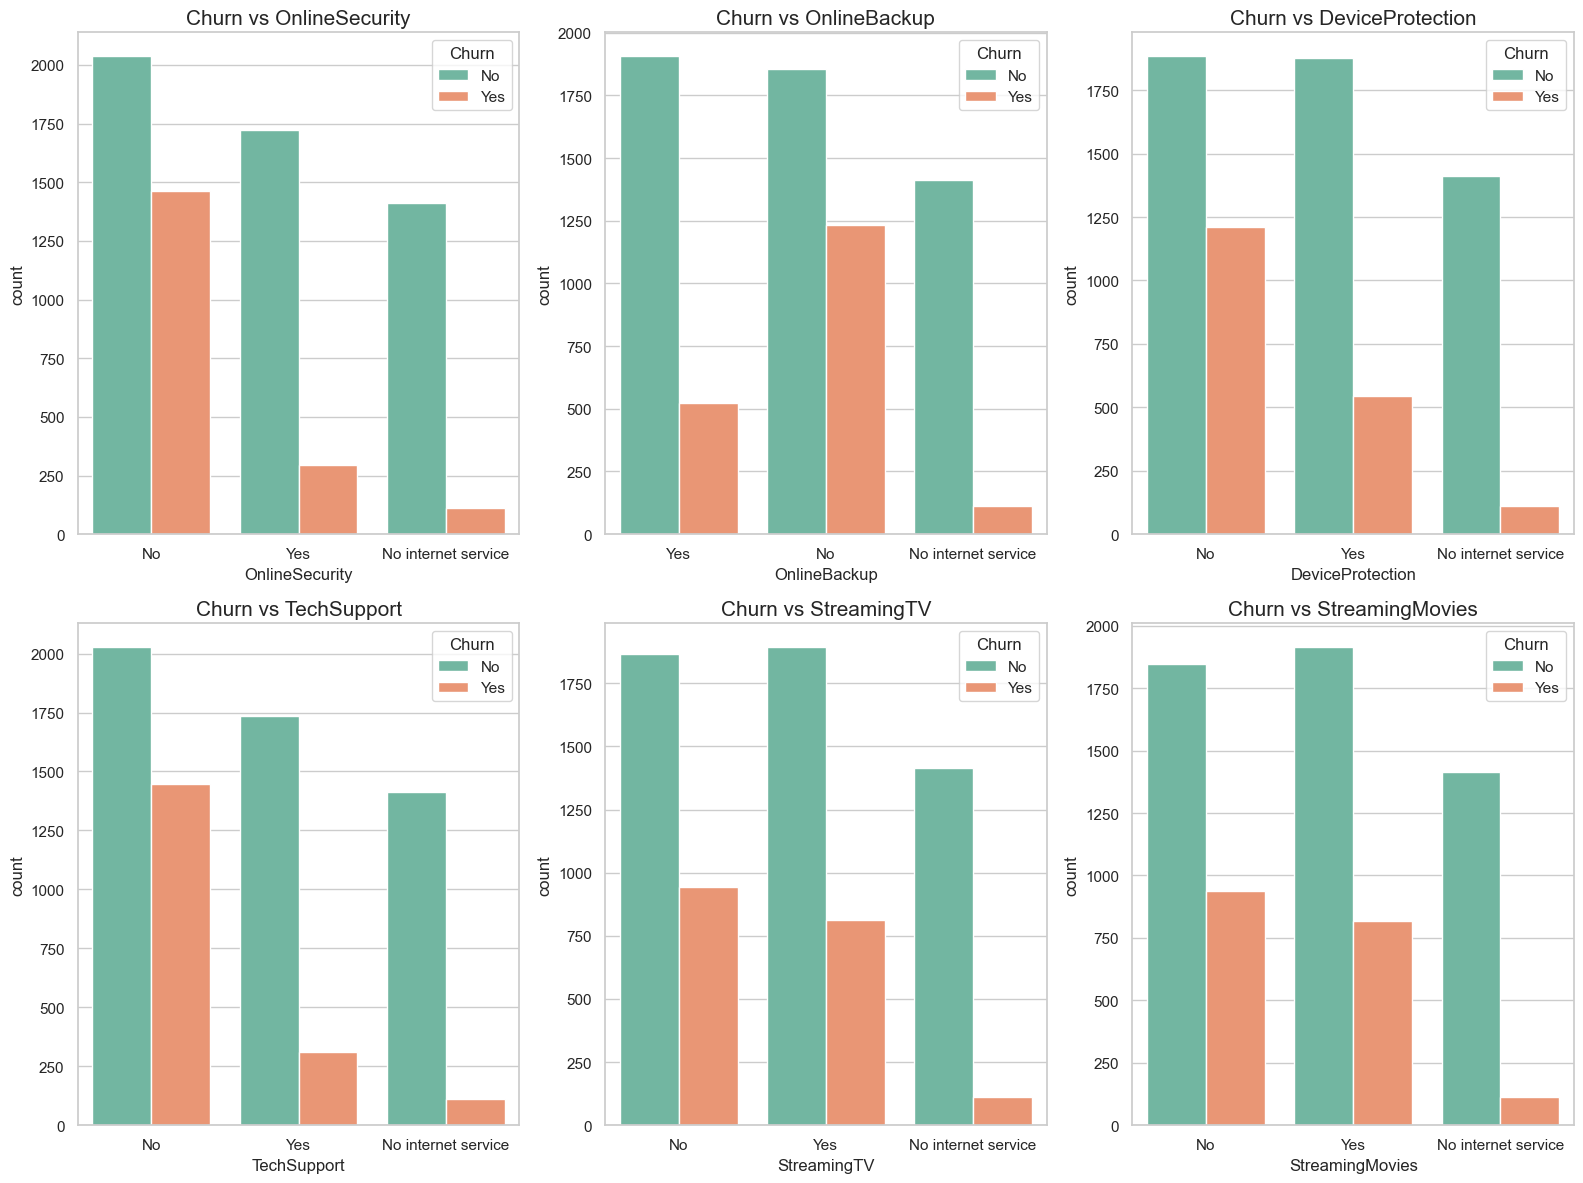

In [205]:
service = ["OnlineSecurity", "OnlineBackup", "DeviceProtection", "TechSupport", "StreamingTV", "StreamingMovies"]

fig, axes = plt.subplots(nrows = 2, ncols = 3, figsize = (16, 12))
for i in range(len(service)):
    sns.countplot(x = service[i], hue = 'Churn', data = tcc, palette = 'Set2', ax = axes[i//3, i%3])
    axes[i//3, i%3].set_title('Churn vs {}'.format(service[i]), fontsize = 15)
    plt.tight_layout()

* Users are less likely to churn if they do not use the network service or if they use the network service but have several value-added services, whereas users who use the network service but do not use other value-added services are more likely to do so. 
* Therefore, to encourage users' purchase of value-added services and enhance user loyalty, we should think about expanding the options for free use of value-added services.

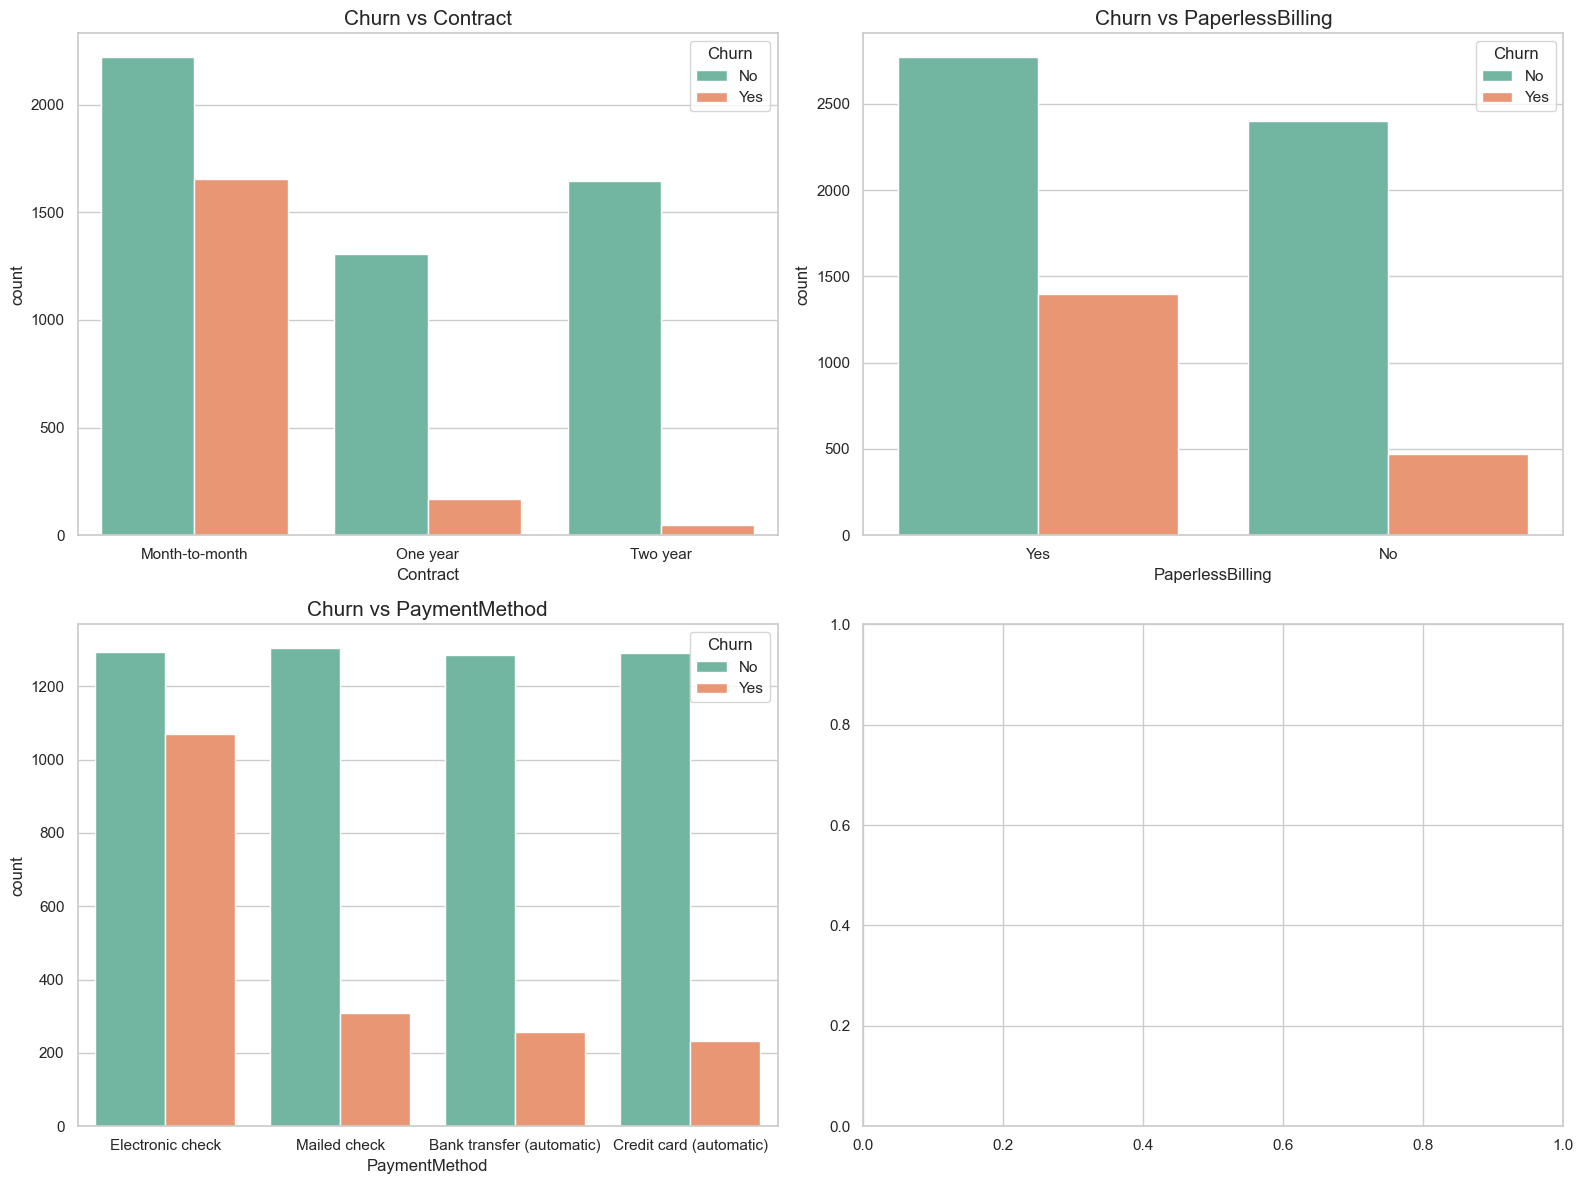

In [206]:
account = ["Contract", "PaperlessBilling", "PaymentMethod"]

fig, axes = plt.subplots(nrows = 2, ncols = 2, figsize = (16, 12))
for i in range(len(account)):
    sns.countplot(x = account[i], hue = 'Churn', data = tcc, palette = 'Set2', ax = axes[i//2, i%2])
    axes[i//2, i%2].set_title('Churn vs {}'.format(account[i]), fontsize = 15)
    plt.tight_layout()

* Users of one-time signing are more likely to churn. Compared to other payment methods, users who pay online are more likely to churn. 
* In order to improve the user life cycle, it may be required to encourage consumers to sign long-term contracts more frequently, whether through discounts or gifts. 
* In order to increase online payment users' happiness, it is also necessary to pay greater attention to the real product experiences of these consumers. 
* Additionally, emphasis can be given to either improving the user experience of online payment itself or offering additional price breaks.

### 2.6.2 Numeric features

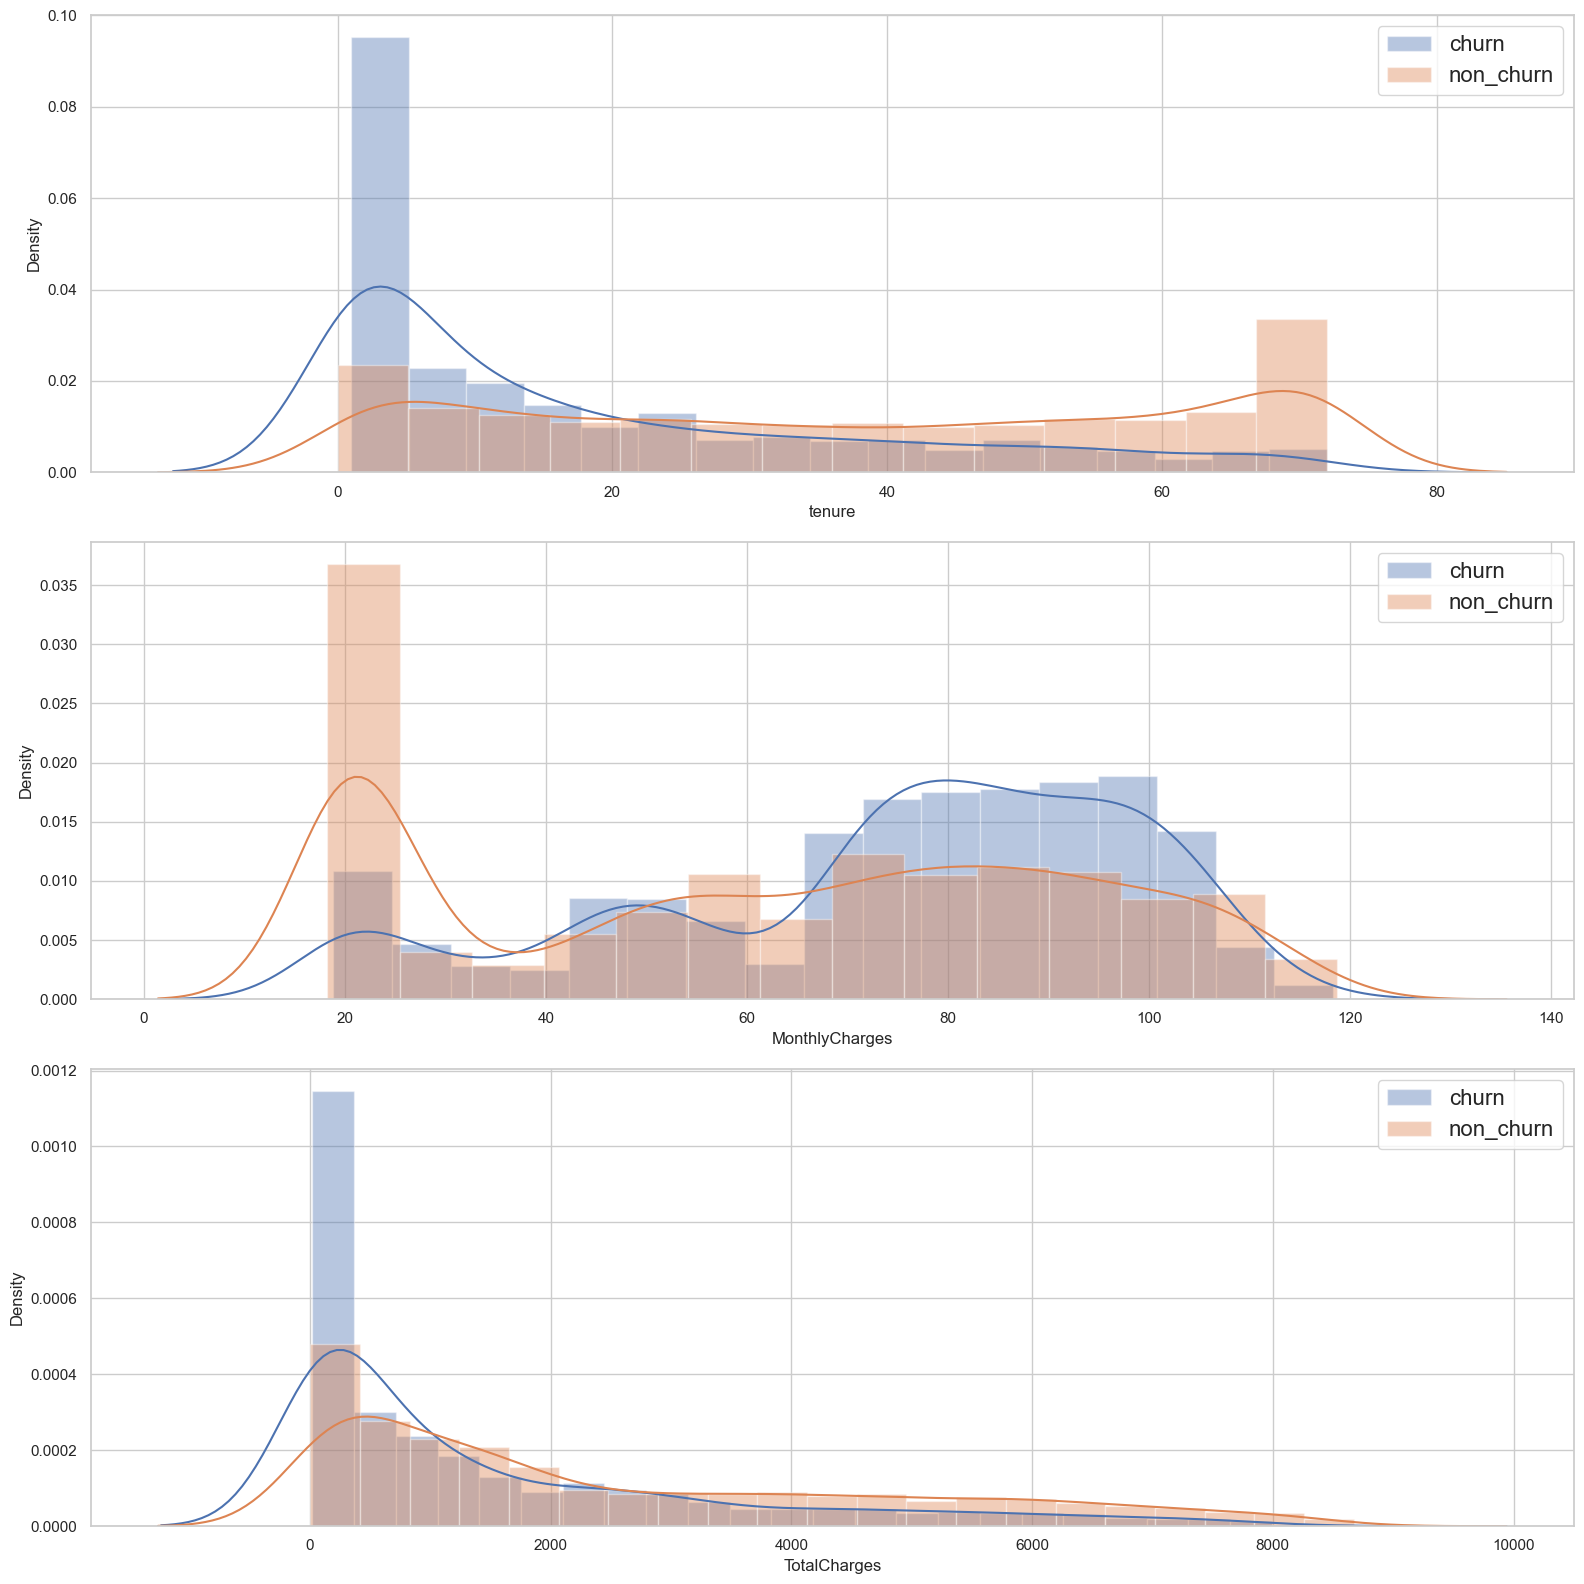

In [227]:
numeric_cols = ['tenure', 'MonthlyCharges', 'TotalCharges']
fig, axes = plt.subplots(ncols = 1, nrows = 3, figsize = (16,16))
for i in range(len(numeric_cols)):
    sns.distplot(tcc[tcc['Churn'] == 'Yes'][numeric_cols[i]], kde = True, ax = axes[i], label = 'churn')
    sns.distplot(tcc[tcc['Churn'] == 'No'][numeric_cols[i]], kde = True, ax = axes[i], label = 'non_churn')
    axes[i].legend(fontsize = 16)
    plt.tight_layout()

* Customers with fewer tenure are more likely to churn
* Higher total charge per month leads to higher customer churn rate

# 3. Logistic Regression

Create interpretable decision tree and logistic regression models, then interpret the outcomes in light of the model output.

## 3.1 Determine metrics and make pipeline

Establish appropriate metrics for evaluating model results before the model training begins. We can use the accuracy rate as the model evaluation metric in this case as the sample ratio of class 0:1 is roughly 3:1 while in the meantime referring to the confusion matrix evaluation metric, f1-Score, and roc-auc values.

In [228]:
# Categorical columns
categorical_cols = ['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 
                'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod']

# numeric columns
numeric_cols = ['tenure', 'MonthlyCharges', 'TotalCharges']

# label
target = 'Churn'

In [229]:
# Convert label to 0/1 
tcc['Churn'].replace(to_replace='Yes', value=1, inplace=True)
tcc['Churn'].replace(to_replace='No',  value=0, inplace=True)

In [230]:
# split training set and test set
train, test = train_test_split(tcc, test_size = 0.3, random_state = 42)

train, test include both features and label

* **Extract lable and features**



In [231]:
Xtrain = train.drop(columns = ['customerID', 'Churn']).copy()
ytrain = train['Churn'].copy()
Xtest = test.drop(columns = ['customerID', 'Churn']).copy()
ytest = test['Churn'].copy()

* **Create ColumnTransformer() and LogisticRegression() estimators**
* **Make pipeline**

In [236]:
# instantiate ColumnTransformer()
ct = ColumnTransformer([
    ('category', OneHotEncoder(drop='if_binary'), categorical_cols), 
    ('numeric', 'passthrough', numeric_cols)
])

# instantiate logistic regression model
lr = LogisticRegression(max_iter = 1000)

# create an ML pipeline
logistic_pipe = make_pipeline(ct, lr)

* **Moodel training**

In [237]:
logistic_pipe.fit(Xtrain, ytrain)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('category',
                                                  OneHotEncoder(drop='if_binary'),
                                                  ['gender', 'SeniorCitizen',
                                                   'Partner', 'Dependents',
                                                   'PhoneService',
                                                   'MultipleLines',
                                                   'InternetService',
                                                   'OnlineSecurity',
                                                   'OnlineBackup',
                                                   'DeviceProtection',
                                                   'TechSupport', 'StreamingTV',
                                                   'StreamingMovies',
                                                   'Contract',
                                                   'PaperlessBilling',
                                                   'PaymentMethod']),
                                                 ('numeric', 'passthrough',
                                                  ['tenure', 'MonthlyCharges',
                                                   'TotalCharges'])])),
                ('logisticregression', LogisticRegression(max_iter=1000))])

* **check the results**

In [238]:
print('accuracy of training set: {}'.format(logistic_pipe.score(Xtrain, ytrain)))
print('accuracy of test set: {}'.format(logistic_pipe.score(Xtest, ytest)))

accuracy of training set: 0.8060851926977688
accuracy of test set: 0.8097491717936584


In [239]:
print(classification_report(y_true=ytest, y_pred=logistic_pipe.predict(Xtest).astype(int)))

              precision    recall  f1-score   support

           0       0.85      0.90      0.87      1539
           1       0.68      0.57      0.62       574

    accuracy                           0.81      2113
   macro avg       0.76      0.74      0.75      2113
weighted avg       0.80      0.81      0.80      2113



The accuracy of logistic regression model is around 80%, which is fairly good for the first try

## 3.2 Hyperparameter tuning for logistic regression

* **Grid Search**

In [242]:
# instantiate ColumnTransformer()
ct = ColumnTransformer([
    ('category', OneHotEncoder(drop='if_binary'), categorical_cols), 
    ('numeric', 'passthrough', numeric_cols)
])

# instantiate logistic regression model
lr = LogisticRegression(max_iter = 1000)

# create an ML pipeline
logistic_pipe = make_pipeline(ct, lr)

# define hyperparameter range
logistic_param = [
    {'logisticregression__penalty': ['l1'], 
     'logisticregression__C': np.arange(0.1, 1.1, 0.2), 
     'logisticregression__solver': ['saga']}, 
    {'logisticregression__penalty': ['l2'], 
     'logisticregression__C': np.arange(0.1, 1.1, 0.2), 
     'logisticregression__solver': ['lbfgs', 'newton-cg', 'sag', 'saga']}
]

# instantiate grid search estimator
lr_search = GridSearchCV(estimator = logistic_pipe,
                         param_grid = logistic_param,
                         n_jobs = 8) 

In [243]:
# train 
begin = time.time()
lr_search.fit(Xtrain, ytrain)
print('running time: {}'.format(time.time() - begin))

running time: 36.35338616371155


In [244]:
print('Best score: {}'.format(lr_search.best_score_))
print('Parameters: {}'.format(lr_search.best_params_))

Best score: 0.8044624746450303
Parameters: {'logisticregression__C': 0.1, 'logisticregression__penalty': 'l2', 'logisticregression__solver': 'lbfgs'}


In [246]:
# Calculate other metrics
print('accuracy of training set: {}'.format(lr_search.score(Xtrain, ytrain)))
print('accuracy of test set: {}'.format(lr_search.score(Xtest, ytest)))
print(classification_report(y_true=ytest, y_pred=lr_search.predict(Xtest).astype(int)))

accuracy of training set: 0.8054766734279919
accuracy of test set: 0.8092759110269758
              precision    recall  f1-score   support

           0       0.84      0.90      0.87      1539
           1       0.68      0.55      0.61       574

    accuracy                           0.81      2113
   macro avg       0.76      0.73      0.74      2113
weighted avg       0.80      0.81      0.80      2113



the best parameters after grid search do not differ much from the default parameters

* **Hyperparameter tuning of ColumnTransformer()**\
use grid search to find the best estimator(N/A, StandardScaler(), KBinsDiscretizer()) in dealing with numerical columns

In [258]:
# # instantiate ColumnTransformer()
ct = ColumnTransformer([
    ('category', OneHotEncoder(drop='if_binary'), categorical_cols), 
    ('numeric', 'passthrough', numeric_cols)
])

ct_para = ['passthrough', 
           StandardScaler(),          # normalization
           KBinsDiscretizer(n_bins=3, encode='ordinal', strategy='kmeans')]    # k-bin disterization

# # instantiate logistic regression model
lr = LogisticRegression(max_iter = 1000)

# create an ML pipeline
logistic_pipe = make_pipeline(ct, lr)

# define hyperparameter range
logistic_param = [
    {'columntransformer__numeric': ct_para, 
     'logisticregression__penalty': ['l1'], 
     'logisticregression__C': np.arange(0.1, 2.1, 0.2).tolist(), 
     'logisticregression__solver': ['saga']}, 
    {'columntransformer__numeric': ct_para, 
     'logisticregression__penalty': ['l2'], 
     'logisticregression__C': np.arange(0.1, 2.1, 0.2).tolist(), 
     'logisticregression__solver': ['lbfgs', 'newton-cg', 'sag', 'saga']}, 
]

# instantiate grid search estimator
lr_search = GridSearchCV(estimator = logistic_pipe,
                         param_grid = logistic_param,
                         n_jobs = 8) 

# train model
begin = time.time()
lr_search.fit(Xtrain, ytrain)
print('running time: {}'.format(time.time() - begin))

running time: 94.40589427947998


In [259]:
print('Best score: {}'.format(lr_search.best_score_))
print('Parameters: {}'.format(lr_search.best_params_))

Best score: 0.8044624746450303
Parameters: {'columntransformer__numeric': 'passthrough', 'logisticregression__C': 0.1, 'logisticregression__penalty': 'l2', 'logisticregression__solver': 'lbfgs'}


In [260]:
# Calculate other metrics
print('accuracy of training set: {}'.format(lr_search.score(Xtrain, ytrain)))
print('accuracy of test set: {}'.format(lr_search.score(Xtest, ytest)))
print(classification_report(y_true=ytest, y_pred=lr_search.predict(Xtest).astype(int)))

accuracy of training set: 0.8054766734279919
accuracy of test set: 0.8092759110269758
              precision    recall  f1-score   support

           0       0.84      0.90      0.87      1539
           1       0.68      0.55      0.61       574

    accuracy                           0.81      2113
   macro avg       0.76      0.73      0.74      2113
weighted avg       0.80      0.81      0.80      2113



According to the cross-validation results, grid search still selects the default parameter.

* **Adjust threshold**

In [307]:
# get predicted label using different threshold
def y_pre(X, threshold = 0.5):
    y_pre = []
    for i in lr_search.predict_proba(X)[:,1]:
        if i >= threshold:
            y_pre.append(1)
        else:
            y_pre.append(0)
    return y_pre

# plot the learning curve of metric vs threshold
def plot_metric(metric):
    metric_tr = []
    for i in np.arange(0.1, 1, 0.1):
        y_pred_tr = y_pre(Xtrain, i)
        metric_tr.append(metric(ytrain, y_pred_tr))
    
    metric_te = []
    for i in np.arange(0.1, 1, 0.1):
        y_pred_te = y_pre(Xtest, i)
        metric_te.append(metric(ytest, y_pred_te))    
    
    plt.plot(np.arange(0.1, 1, 0.1), metric_tr, marker = 'o', label = 'train')
    plt.plot(np.arange(0.1, 1, 0.1), metric_te, marker = 's', label = 'test')
    plt.title(str(metric))
    plt.legend(loc = 'best')

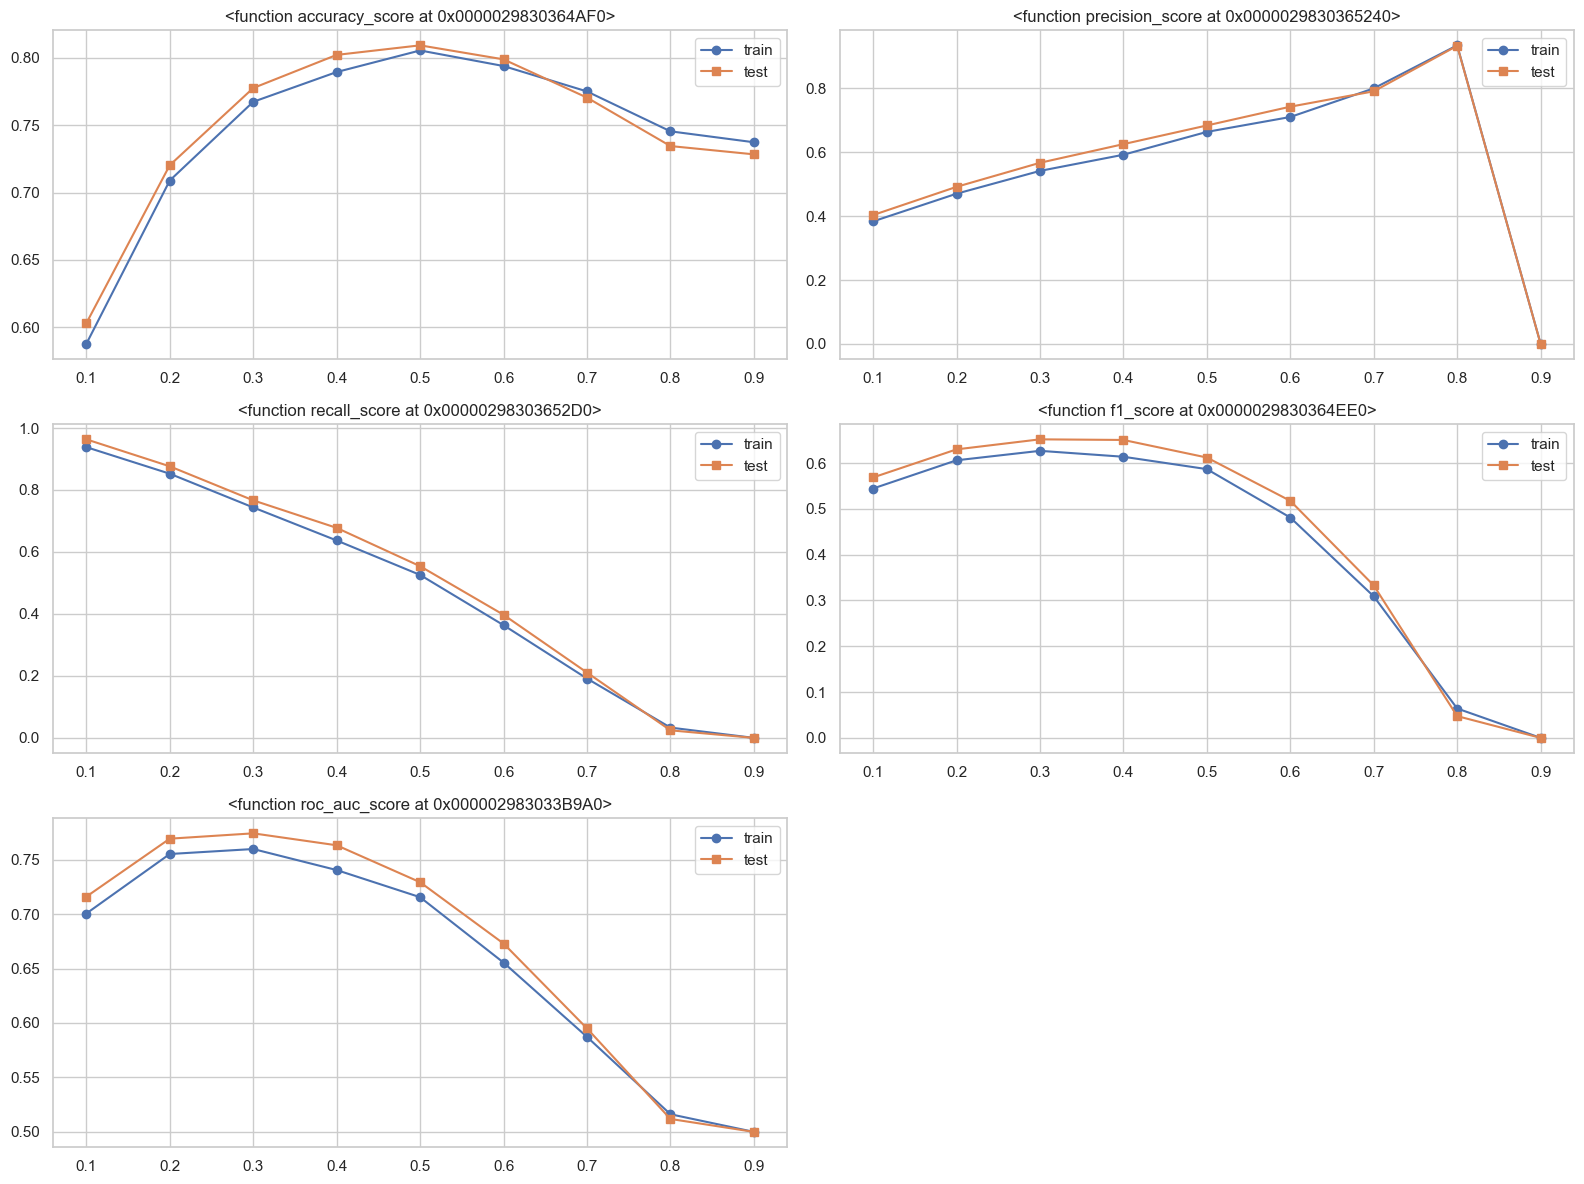

In [314]:
metric = [accuracy_score, precision_score, recall_score, f1_score, roc_auc_score]
plt.figure(figsize = (16, 12))
for i in range(len(metric)):
    plt.subplot(3, 2, i+1)
    plot_metric(metric[i])
    plt.tight_layout()

When we choose 0.3 as threshold, model has performance on accuracy, f1_score and roc_auc_score

## 3.4 Interpretation of logistic regression model


* **check the coefficient of each feature**

In [316]:
lr_best.named_steps

{'columntransformer': ColumnTransformer(transformers=[('category', OneHotEncoder(drop='if_binary'),
                                  ['gender', 'SeniorCitizen', 'Partner',
                                   'Dependents', 'PhoneService', 'MultipleLines',
                                   'InternetService', 'OnlineSecurity',
                                   'OnlineBackup', 'DeviceProtection',
                                   'TechSupport', 'StreamingTV',
                                   'StreamingMovies', 'Contract',
                                   'PaperlessBilling', 'PaymentMethod']),
                                 ('numeric', 'passthrough',
                                  ['tenure', 'MonthlyCharges', 'TotalCharges'])]),
 'logisticregression': LogisticRegression(C=0.1, max_iter=1000)}

In [344]:
lr_best = lr_search.best_estimator_
coefficient = lr_best.named_steps['logisticregression'].coef_.flatten()
print(coefficient)

[-8.16567924e-02  2.00204999e-01 -4.30173996e-02 -1.71380519e-01
 -1.87591046e-01 -2.62884765e-01  3.49706905e-02  7.52937190e-02
 -3.27614196e-01  2.86175921e-01 -1.11182081e-01  2.50180211e-01
 -1.11182081e-01 -2.91618485e-01  8.69635149e-02 -1.11182081e-01
 -1.28401789e-01  1.51168075e-02 -1.11182081e-01 -5.65550818e-02
  2.19493956e-01 -1.11182081e-01 -2.60932231e-01 -6.39854728e-02
 -1.11182081e-01  2.25471985e-02 -1.40582881e-01 -1.11182081e-01
  9.91446069e-02  2.55753786e-01 -1.40168482e-01 -2.68205659e-01
  2.34595803e-01 -8.64762420e-02 -1.28285481e-01  2.87030260e-01
 -2.24888892e-01 -5.92077271e-02  1.95262887e-03  2.78620116e-04]


In [345]:
# get one-hot encoder estimator
categorical_features = lr_best.named_steps['columntransformer'].named_transformers_['category'].get_feature_names(categorical_cols)

In [346]:
all_features = categorical_features.tolist() + numeric_cols

In [347]:
# create a series to put coefficient and the coresponding feature name
weights = pd.Series(coefficient, all_features)
print(weights)

gender_Male                               -0.081657
SeniorCitizen_1                            0.200205
Partner_Yes                               -0.043017
Dependents_Yes                            -0.171381
PhoneService_Yes                          -0.187591
MultipleLines_No                          -0.262885
MultipleLines_No phone service             0.034971
MultipleLines_Yes                          0.075294
InternetService_DSL                       -0.327614
InternetService_Fiber optic                0.286176
InternetService_No                        -0.111182
OnlineSecurity_No                          0.250180
OnlineSecurity_No internet service        -0.111182
OnlineSecurity_Yes                        -0.291618
OnlineBackup_No                            0.086964
OnlineBackup_No internet service          -0.111182
OnlineBackup_Yes                          -0.128402
DeviceProtection_No                        0.015117
DeviceProtection_No internet service      -0.111182
DeviceProtec

<function matplotlib.pyplot.show(close=None, block=None)>

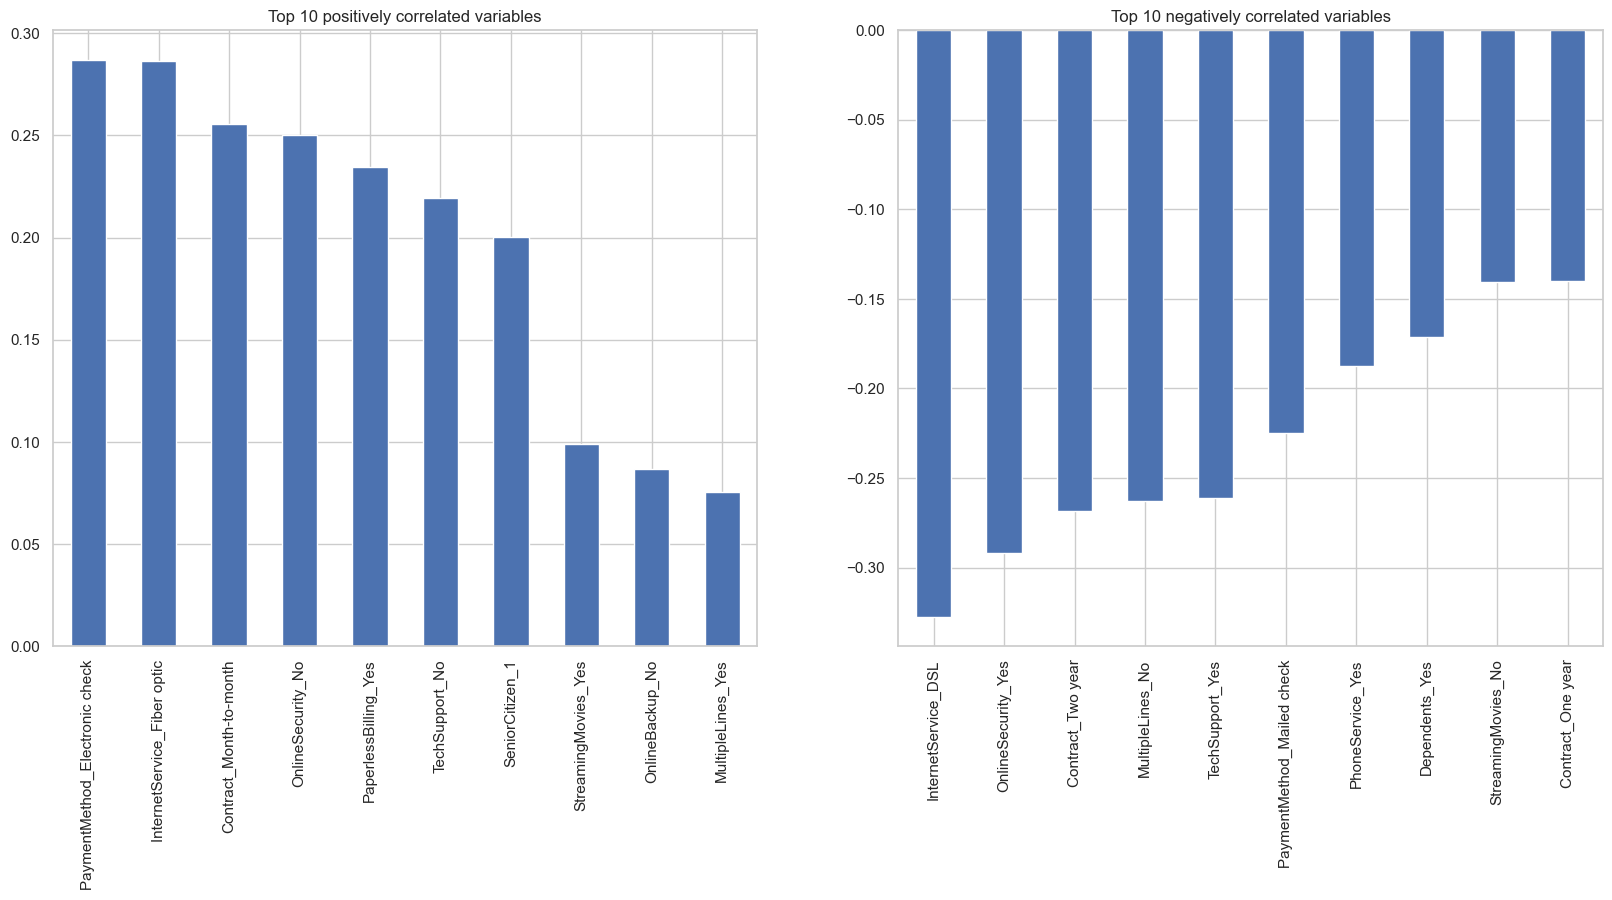

In [349]:
# Visualizaton
plt.figure(figsize = (20, 8))
plt.subplot(121)
weights.sort_values(ascending = False)[: 10].plot(kind = 'bar')
plt.title('Top 10 positively correlated variables')

plt.subplot(122)
weights.sort_values(ascending = True)[: 10].plot(kind = 'bar')
plt.title('Top 10 negatively correlated variables')
plt.show

* Users are more likely to churn when contract is 'Month-to-month', while users are more likely to retain when contract is 'Two year'.
* For Contract, the presence of 'Month-to-month' increases the log-odds of churn by 50% (approximately 10% increase in probability), while the presence of 'Two year' decreases the log-odds of churn by 50% (approximately 10% decrease in probability).
* The impact of 'Contract_Month-to-month' is twice as high as that of 'SeniorCitizen' in terms of churning rate. 

# 4. Decision Tree Model

In [352]:
# instantiate ColumnTransformer()
ct_tree = ColumnTransformer([
    ('category', OneHotEncoder(drop='if_binary'), categorical_cols), 
    ('numeric', 'passthrough', numeric_cols)
])

# instantiate decision tree model
dtc = DecisionTreeClassifier()

# create an ML pipeline
dtc_pipe = make_pipeline(ct_tree, dtc)

# train tree model
dtc_pipe.fit(Xtrain, ytrain)

# Calculate metrics
print('accuracy of training set: {}'.format(dtc_pipe.score(Xtrain, ytrain)))
print('accuracy of test set: {}'.format(dtc_pipe.score(Xtest, ytest)))
print(classification_report(y_true=ytest, y_pred=dtc_pipe.predict(Xtest).astype(int)))

accuracy of training set: 0.9983772819472616
accuracy of test set: 0.7406530998580217
              precision    recall  f1-score   support

           0       0.82      0.83      0.82      1539
           1       0.52      0.51      0.52       574

    accuracy                           0.74      2113
   macro avg       0.67      0.67      0.67      2113
weighted avg       0.74      0.74      0.74      2113



The accuracy score of test set is much lower training set, indicating severe overfitting

* **Grid Search**

In [353]:
# instantiate ColumnTransformer()
ct_tree = ColumnTransformer([
    ('category', OrdinalEncoder(), categorical_cols), 
    ('numeric', 'passthrough', numeric_cols)
])

# instantiate decision tree model
dtc = DecisionTreeClassifier()

# create an ML pipeline 
dtc_pipe = make_pipeline(ct_tree, dtc)

# define hyperparameter range
dtc_param = {'decisiontreeclassifier__ccp_alpha': np.arange(0, 1, 0.2),
              'decisiontreeclassifier__max_depth': np.arange(2, 8, 1), 
              'decisiontreeclassifier__min_samples_split': np.arange(2, 5, 1), 
              'decisiontreeclassifier__min_samples_leaf': np.arange(1, 4, 1), 
              'decisiontreeclassifier__max_leaf_nodes':np.arange(6, 10, 1)}

# instantiate grid search estimator
dtc_search = GridSearchCV(estimator = dtc_pipe, 
                          param_grid = dtc_param,
                          n_jobs = 8)

# train tree model
begin = time.time()
dtc_search.fit(Xtrain, ytrain)
print('running time: {}'.format(time.time() - begin))

running time: 42.93894553184509


In [354]:
print('Best score: {}'.format(dtc_search.best_score_))
print('Parameters: {}'.format(dtc_search.best_params_))

Best score: 0.7888438133874239
Parameters: {'decisiontreeclassifier__ccp_alpha': 0.0, 'decisiontreeclassifier__max_depth': 5, 'decisiontreeclassifier__max_leaf_nodes': 8, 'decisiontreeclassifier__min_samples_leaf': 1, 'decisiontreeclassifier__min_samples_split': 2}


In [356]:
# Calculate metrics
print('accuracy of training set: {}'.format(dtc_search.score(Xtrain, ytrain)))
print('accuracy of test set: {}'.format(dtc_search.score(Xtest, ytest)))
print(classification_report(y_true=ytest, y_pred=dtc_search.predict(Xtest).astype(int)))

accuracy of training set: 0.7918864097363083
accuracy of test set: 0.7808802650260294
              precision    recall  f1-score   support

           0       0.81      0.92      0.86      1539
           1       0.66      0.40      0.50       574

    accuracy                           0.78      2113
   macro avg       0.73      0.66      0.68      2113
weighted avg       0.77      0.78      0.76      2113



* Accuracy is close between train set and test set, which means that overfitting problem is fixed.
* The accuracy score of desicion tree is near 80%, which is close to the accuracy of logistic regression.
* In most cases, decision trees is more powerful than logistic regression model  (logistic regression can only construct linear decision boundaries, while decision trees can construct folded decision boundaries). So the results indicate that the dataset itself is challenging to model. 

* **Intepretation of Decision Tree Model**

In [357]:
dtc_best = dtc_search.best_estimator_
dtc_fi = dtc_best.named_steps['decisiontreeclassifier'].feature_importances_
print(dtc_fi)

[0.         0.         0.         0.         0.         0.
 0.09172467 0.16459205 0.         0.         0.         0.
 0.         0.59485158 0.         0.         0.10294988 0.02570471
 0.0201771 ]


A lot of features' importance is 0, which means that they make no contribution to the tree model

In [358]:
cols = categorical_cols + numeric_cols

In [359]:
dtc_feature_importances = pd.Series(dtc_fi, index = cols)
print(dtc_feature_importances)

gender              0.000000
SeniorCitizen       0.000000
Partner             0.000000
Dependents          0.000000
PhoneService        0.000000
MultipleLines       0.000000
InternetService     0.091725
OnlineSecurity      0.164592
OnlineBackup        0.000000
DeviceProtection    0.000000
TechSupport         0.000000
StreamingTV         0.000000
StreamingMovies     0.000000
Contract            0.594852
PaperlessBilling    0.000000
PaymentMethod       0.000000
tenure              0.102950
MonthlyCharges      0.025705
TotalCharges        0.020177
dtype: float64


<AxesSubplot:>

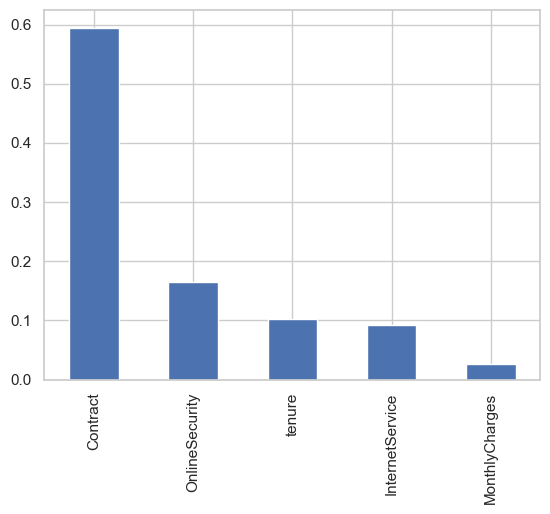

In [360]:
dtc_feature_importances.sort_values(ascending = False)[: 5].plot(kind = 'bar')

Similar to logistic regression mode, the top 5 important features are Contract, OnlineSecurity, InternetService, tenure, and MonthlyCharges.

# 5. Conclusions

* According to logistic regression and desicion tree model, Contract, Tenure, OnlineSecurity, SeniorCitizens are features that have a strong impact on churn rate. 
* We need to pay special attention to elderly customers who pay monthly and do not use online services, and we should offer coupons and discounts to them in order to keep them from leaving.
* The majority of non-monthly subscribers with a monthly spend of less than 92.5 have a higher retention rate.
* Among monthly paying subscribers, those who did not purchase OnlineSecurity and had been on the network for less than 8 months and purchased InternetService had three times as many churned customers as retained customers.